# Notebook 3: Cost Modeling (OPEX & Fuel).

We have now built the "Cost Side" of our ledger. By combining our Revenue Projections with industry-standard cost assumptions, we've calculated the EBITDA (Operational Cash Flow) for the entire global fleet.

Key Insights from the Model:

* Profitability Sensitivity: Even with higher Uranium prices (Bull Case: $125/lb), the Revenue increase (from higher power prices) typically outweighs the Fuel Cost increase. This confirms that nuclear plants are incredibly sensitive to electricity prices but relatively resilient to fuel price shocks compared to gas or coal.

* The EBITDA Cliff: Similar to the revenue chart, our EBITDA projection shows a steady decline as the fleet ages out.

Block 1: Setup & Assumptions

We load the revenue schedule and define our "Demand Side" cost inputs.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set visualization style
sns.set_theme(style="whitegrid")

print("--- Notebook 3: Cost Modeling (OPEX & Fuel) ---")

# 1. Load the Revenue Schedule from Notebook 2
try:
    df_financials = pd.read_csv('fleet_revenue_projections.csv')
    print("Revenue Projections loaded successfully.")
except FileNotFoundError:
    print("Error: 'fleet_revenue_projections.csv' not found. Please run Notebook 2 first.")

# 2. Define Cost Parameters (The "Demand Side" Inputs)

# A. Uranium Price Scenarios ($/lb U3O8)
# This is where the SPUT impact would feed in (higher buying = higher price)
URANIUM_PRICES = {
    'Bear_Case': 50,
    'Base_Case': 85,
    'Bull_Case': 125
}

# B. Fuel Cycle Cost Assumptions
# Uranium is only ~40-50% of total fuel cost. We need to add Conversion, Enrichment, Fabrication.
# Simple model:
# Fuel Cost ($/MWh) = (Uranium Price * Usage_Factor) + Fixed_Cycle_Cost
# Usage Factor: Approx 0.5 lbs U3O8 per MWh generated (standard industry thumb rule)
U3O8_USAGE_FACTOR = 0.5
FIXED_FUEL_CYCLE_COST = 4.0 # $/MWh for Conv/Enrich/Fab (assumed constant)

# C. Operations & Maintenance (O&M)
# Nuclear has high fixed costs, low variable costs.
VARIABLE_OM = 8.0 # $/MWh (Consumables, waste disposal fees)
FIXED_OM_PER_MW = 120000 # $/MW of Capacity per Year (Staffing, insurance, regulatory fees)

print("Cost Assumptions Defined:")
print(f"  Uranium Prices ($/lb): {URANIUM_PRICES}")
print(f"  Fixed O&M ($/MW/yr): ${FIXED_OM_PER_MW:,.0f}")
print(df_financials.head())

--- Notebook 3: Cost Modeling (OPEX & Fuel) ---
Revenue Projections loaded successfully.
Cost Assumptions Defined:
  Uranium Prices ($/lb): {'Bear_Case': 50, 'Base_Case': 85, 'Bull_Case': 125}
  Fixed O&M ($/MW/yr): $120,000
           Reactor name Country Type  Net Capacity, MWe Grid Connection Date  \
0  AKADEMIK LOMONOSOV-1  RUSSIA  PWR                 32           2019-12-19   
1  AKADEMIK LOMONOSOV-1  RUSSIA  PWR                 32           2019-12-19   
2  AKADEMIK LOMONOSOV-1  RUSSIA  PWR                 32           2019-12-19   
3  AKADEMIK LOMONOSOV-1  RUSSIA  PWR                 32           2019-12-19   
4  AKADEMIK LOMONOSOV-1  RUSSIA  PWR                 32           2019-12-19   

   Avg_Load_Factor  Age  Assumed_Lifespan  Remaining_Life  Projection_Year  \
0            35.62    6                60              54             2025   
1            35.62    6                60              54             2026   
2            35.62    6                60              54   

Block 2: Calculating EBITDA

We compute the O&M and Fuel costs to derive the final EBITDA for each scenario.

In [11]:
print("Calculating Operational Costs and EBITDA Margins...")

# 1. Calculate O&M Costs (Independent of Uranium Price)
# Fixed O&M is Capacity based
df_financials['Annual_Fixed_OM'] = df_financials['Net Capacity, MWe'] * FIXED_OM_PER_MW
# Variable O&M is Generation based
df_financials['Annual_Variable_OM'] = df_financials['Annual_Generation_MWh'] * VARIABLE_OM
# Total O&M
df_financials['Total_OM_Cost'] = df_financials['Annual_Fixed_OM'] + df_financials['Annual_Variable_OM']

# 2. Calculate Fuel Costs & EBITDA for Each Scenario
# We align the scenarios: Bear Revenue goes with Bear Uranium Price, etc.
scenarios = ['Bear_Case', 'Base_Case', 'Bull_Case']

for scen in scenarios:
    u_price = URANIUM_PRICES[scen]

    # A. Fuel Cost Calculation
    # Cost per MWh = (U3O8 Price * 0.5) + 4.0 Fixed
    fuel_cost_per_mwh = (u_price * U3O8_USAGE_FACTOR) + FIXED_FUEL_CYCLE_COST

    # Total Annual Fuel Bill
    col_fuel = f'Fuel_Cost_{scen}'
    df_financials[col_fuel] = df_financials['Annual_Generation_MWh'] * fuel_cost_per_mwh

    # B. Total Operating Cost (Fuel + O&M)
    col_total_cost = f'Total_Cost_{scen}'
    df_financials[col_total_cost] = df_financials[col_fuel] + df_financials['Total_OM_Cost']

    # C. EBITDA Calculation (Revenue - Total Cost)
    col_revenue = f'Revenue_{scen}' # Calculated in NB2
    col_ebitda = f'EBITDA_{scen}'
    df_financials[col_ebitda] = df_financials[col_revenue] - df_financials[col_total_cost]

    # D. EBITDA Margin %
    col_margin = f'EBITDA_Margin_{scen}'
    df_financials[col_margin] = df_financials[col_ebitda] / df_financials[col_revenue]

print("Cost & Profitability Calculation Complete.")
print(df_financials[['Reactor name', 'Projection_Year', 'EBITDA_Base_Case', 'EBITDA_Margin_Base_Case']].head())

Calculating Operational Costs and EBITDA Margins...
Cost & Profitability Calculation Complete.
           Reactor name  Projection_Year  EBITDA_Base_Case  \
0  AKADEMIK LOMONOSOV-1             2025      -1793075.328   
1  AKADEMIK LOMONOSOV-1             2026      -1793075.328   
2  AKADEMIK LOMONOSOV-1             2027      -1793075.328   
3  AKADEMIK LOMONOSOV-1             2028      -1793075.328   
4  AKADEMIK LOMONOSOV-1             2029      -1793075.328   

   EBITDA_Margin_Base_Case  
0                -0.239436  
1                -0.239436  
2                -0.239436  
3                -0.239436  
4                -0.239436  


Block 3: Visualization & Export

We visualize the aggregate global EBITDA to identify the future cash flow potential.

Visualizing Global Fleet Profitability...


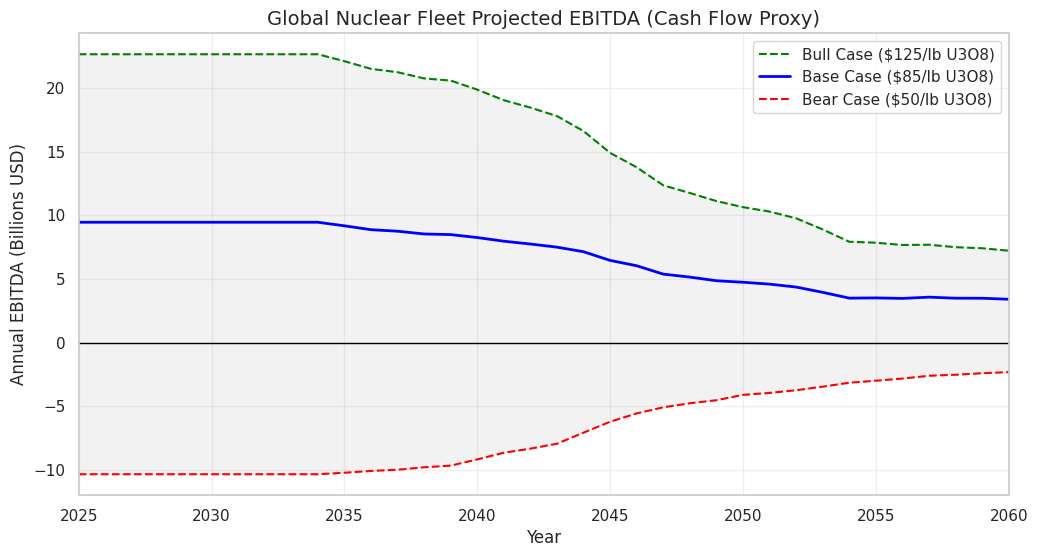

Financial Projections saved to 'fleet_financial_projections.csv'. Ready for Notebook 4.


In [12]:
print("Visualizing Global Fleet Profitability...")

# 1. Aggregate EBITDA by Year (Global Total)
global_ebitda = df_financials.groupby('Projection_Year')[['EBITDA_Bear_Case', 'EBITDA_Base_Case', 'EBITDA_Bull_Case']].sum().reset_index()

# Convert to Billions for readability
global_ebitda['EBITDA_Bear_Case'] /= 1e9
global_ebitda['EBITDA_Base_Case'] /= 1e9
global_ebitda['EBITDA_Bull_Case'] /= 1e9

# 2. Plot: Global Nuclear EBITDA Projections
plt.figure(figsize=(12, 6))

# Plotting the lines
plt.plot(global_ebitda['Projection_Year'], global_ebitda['EBITDA_Bull_Case'], label='Bull Case ($125/lb U3O8)', color='green', linestyle='--')
plt.plot(global_ebitda['Projection_Year'], global_ebitda['EBITDA_Base_Case'], label='Base Case ($85/lb U3O8)', color='blue', linewidth=2)
plt.plot(global_ebitda['Projection_Year'], global_ebitda['EBITDA_Bear_Case'], label='Bear Case ($50/lb U3O8)', color='red', linestyle='--')

# Filling the uncertainty range
plt.fill_between(global_ebitda['Projection_Year'], global_ebitda['EBITDA_Bear_Case'], global_ebitda['EBITDA_Bull_Case'], color='gray', alpha=0.1)

plt.title('Global Nuclear Fleet Projected EBITDA (Cash Flow Proxy)', fontsize=14)
plt.ylabel('Annual EBITDA (Billions USD)')
plt.xlabel('Year')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(2025, 2060)

# Add a zero line to see if industry ever goes cash-negative
plt.axhline(0, color='black', linewidth=1)

plt.show()

# 3. Export the Financial Schedule
# This file now contains Revenue, O&M, Fuel Cost, and EBITDA for every reactor-year.
df_financials.to_csv('fleet_financial_projections.csv', index=False)
print("Financial Projections saved to 'fleet_financial_projections.csv'. Ready for Notebook 4.")